In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [10]:
## Load training data
feature_df = pd.read_csv('data/realtime_data_prepared.csv')
label_df = pd.read_csv('data/watch_data_prepared.csv')
sleep_label_df = label_df[(label_df['sleep_mode'] == 1) | (label_df['sleep_mode'] == 2)]

sleep_feature_set = []
for index, row in sleep_label_df.iterrows():
    df = feature_df[(feature_df['day'] == int(row['testtime'][9])) & (feature_df['hour'] == int(row['testtime'][11:13])) & (feature_df['min'] == int(row['testtime'][14:16]))]
    df = df[df['breath_rate'] != 0]
    sleep_feature_set.append(df)
    
sleep_feature_df = pd.concat(sleep_feature_set)
    


In [11]:
sleep_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13389 entries, 1661 to 25745
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           13389 non-null  int64 
 1   move_state   13389 non-null  int64 
 2   move_value   13389 non-null  int64 
 3   heart_rate   13389 non-null  int64 
 4   breath_rate  13389 non-null  int64 
 5   sleep_state  13389 non-null  int64 
 6   sound_value  13389 non-null  int64 
 7   temp_value   13389 non-null  int64 
 8   time         13389 non-null  int64 
 9   new_time     13389 non-null  int64 
 10  testtime     13389 non-null  object
 11  day          13389 non-null  int64 
 12  hour         13389 non-null  int64 
 13  min          13389 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 1.5+ MB


Epoch [10/50], Loss: 0.0007
Epoch [20/50], Loss: 0.0052
Epoch [30/50], Loss: 0.0008
Epoch [40/50], Loss: 0.0093
Epoch [50/50], Loss: 0.0012


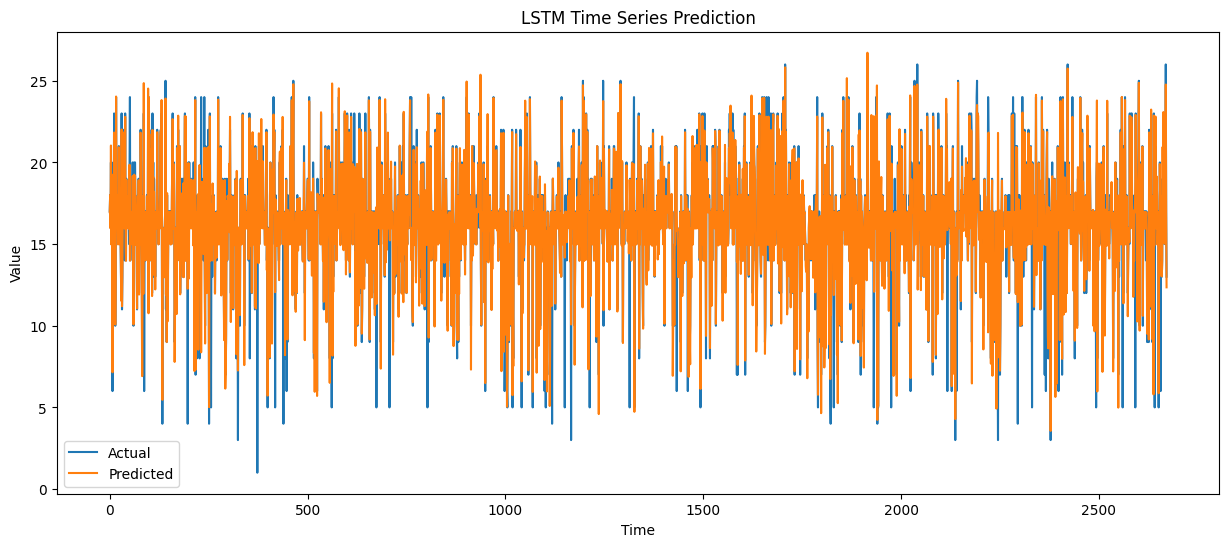

Model saved successfully.
Model loaded successfully.


/tmp/ipykernel_3973109/679499953.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('../models/lstm_breath_model.pth'))


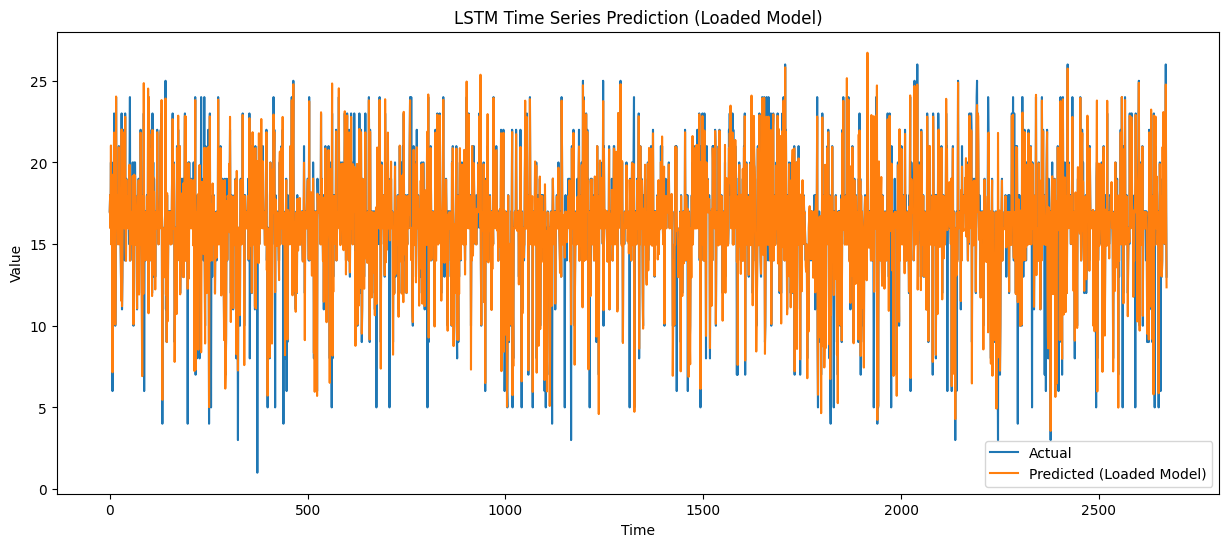

In [12]:
# 시드 설정
torch.manual_seed(0)
np.random.seed(0)

# 데이터 전처리
scaler = MinMaxScaler()
scaler = scaler.fit(sleep_feature_df['breath_rate'].values.reshape(-1, 1))
# 스케일러 저장
import pickle
with open('../models/breath_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
scaled_data = scaler.transform(sleep_feature_df['breath_rate'].values.reshape(-1, 1))

# 시퀀스 데이터셋 클래스
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], 
                self.data[idx+self.seq_length])

# LSTM 모델 클래스
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 하이퍼파라미터 설정
seq_length = 30
hidden_size = 50
num_layers = 1
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# 데이터셋 및 데이터로더 생성
dataset = TimeSeriesDataset(scaled_data, seq_length)
train_size = int(len(dataset) * 0.8)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델, 손실 함수, 옵티마이저 초기화
model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 함수
def train_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    return np.array(predictions), np.array(actuals)

# 모델 학습
train_model(model, train_loader, num_epochs)

# 모델 평가
predictions, actuals = evaluate_model(model, test_loader)

# 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(actuals), label='Actual')
plt.plot(scaler.inverse_transform(predictions), label='Predicted')
plt.legend()
plt.title('LSTM Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# 모델 저장
torch.save(model.state_dict(), '../models/lstm_breath_model.pth')
print("Model saved successfully.")

# 모델 로드
loaded_model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
loaded_model.load_state_dict(torch.load('../models/lstm_breath_model.pth'))
loaded_model.eval()
print("Model loaded successfully.")

# 로드된 모델로 예측
loaded_predictions, _ = evaluate_model(loaded_model, test_loader)

# 로드된 모델의 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(actuals), label='Actual')
plt.plot(scaler.inverse_transform(loaded_predictions), label='Predicted (Loaded Model)')
plt.legend()
plt.title('LSTM Time Series Prediction (Loaded Model)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()